# Diamond characteristics as predictors of diamond pricing

## Introduction

Diamonds dataset by ggplot2 describes different diamond characteristics and diamond prices. It's crucial for people in diamond business and customers to be able to understand the correct pricing of diamonds. Understanding best predictors of pricing allows people to ensure they don't get scammed in the business. It also allows us to create models which predict the correct pricing range of the diamonds.

We would like to know which dimensional characteristics of diamond have the greatest effect on diamond pricing. To test the relevance of variables to the pricing we are going to employ different variable selection methods such as selection using p-values and LASSO analysis.

Let's begin by loading the data and important libraries.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import tabulate
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

## Analysing data

### Variables

Let us start by exploring contents of the data.

In [3]:
df = pd.read_csv('diamonds.csv')
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Data contains information about diamonds
* carat: which is unit used to describe weight of diamond
* cut: how well diamond has been cut
* color: coloring of diamond
* clarity: measurement how clear diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
* depth: depth presentage based on dimensions of x, y, z
* table: width of the diamond relative to widest point
* price: pricing of the diamond in US dollars
* x, y, z: dimensions of diamond: length, width and depth respectively

In [4]:
#distributional data labels
num_labels = ['carat', 'x', 'y', 'z', 'depth', 'price', 'table']
#categorial data labels
feat_labels = ['cut', 'color', 'clarity']

#### Distributional data

To understand distributional data we first want to analyze its descriptive statistics. Let us first create a table.

In [5]:
table = [["","mean","median","1. quantile"
          , "3. quantile", "std", "minimum", "maximum", "skewness"]]
for i in range(len(num_labels)):
    data = df[num_labels[i]].values
    table.append([num_labels[i]])
    table[i + 1].extend([
        np.mean(data),
        np.median(data),
        np.percentile(data, 25),
        np.percentile(data, 75),
        np.sqrt(np.var(data)),
        np.min(data),
        np.max(data),
        (np.mean((data - data.mean()) ** 3))/ (np.std(data, ddof = 1) ** 3)
    ])
display(HTML(tabulate.tabulate(table, tablefmt='html')))

,mean,median,1. quantile,3. quantile,std,minimum,maximum,skewness
carat,0.7979397478680014,0.7,0.4,1.04,0.47400685050996644,0.2,5.01,1.1165838166902704
x,5.731157211716722,5.7,4.71,6.54,1.1217503485171316,0.0,10.74,0.37865528193101833
y,5.734525954764553,5.71,4.72,6.54,1.1421240869900022,0.0,58.9,2.434031336253205
z,3.5387337782721544,3.53,2.91,4.04,0.7056923054027403,0.0,31.8,1.522337887002773
depth,61.749404894327036,61.8,61.0,62.5,1.4326080390046028,43.0,79.0,-0.08228944938258445
price,3932.799721913237,2401.0,950.0,5324.25,3989.4027576288736,326,18823,1.6183052736348653
table,57.45718390804598,57.0,56.0,59.0,2.2344698499837317,43.0,95.0,0.7968515279799152


We notice that all variables but depth seem to be heavily skewed to right. This is expected due to all of variables being non-negative characteristics of the diamond. Also variance is kinda high for distributions to resemble a single normal distribution. Something else must be in play.

Depth seems to form simple unimodal probability distribution since the quantiles seem to be equally distributed and the skewness is almost zero.

In [6]:
# function for removing the outliers from data
def robust_data(data, outlier_persent):
    lower = np.partition(data, int(data.size * outlier_persent))
    lower = lower[int(data.size * outlier_persent)]
    upper = np.partition(data, int(data.size * (1 - outlier_persent)))
    upper = upper[int(data.size * (1 - outlier_persent))]
    return data[(data > lower) & (data < upper)]

def robust_pair(feat, label, outlier_persent):
    lower = np.partition(feat, int(feat.size * outlier_persent))
    lower = lower[int(feat.size * outlier_persent)]
    upper = np.partition(feat, int(feat.size * (1 - outlier_persent)))
    upper = upper[int(feat.size * (1 - outlier_persent))]
    return feat[(feat > lower) & (feat < upper)] , label[(feat > lower) & (feat < upper)]

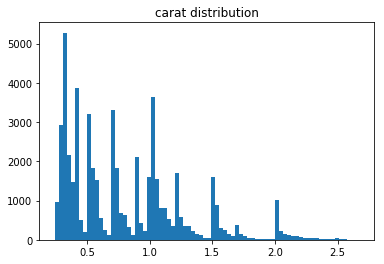

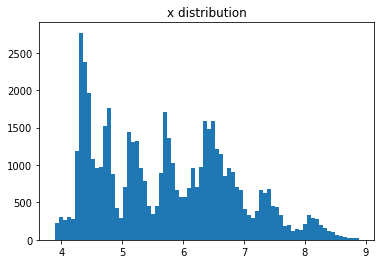

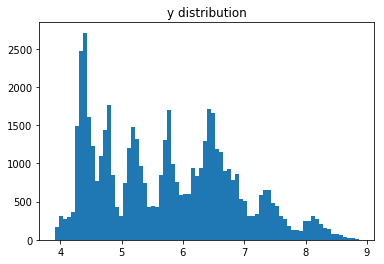

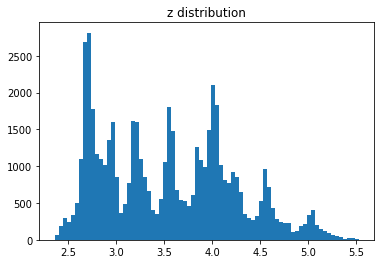

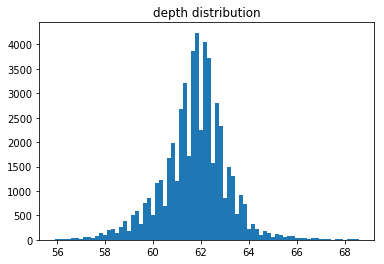

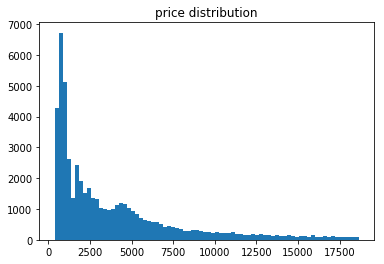

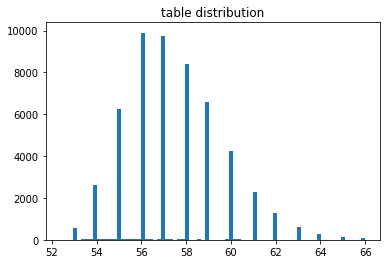

In [7]:
for label in num_labels:
    data = df[label].values
    data = robust_data(data, 0.001)
    plt.hist(data, bins = 'rice', range = [np.min(data), np.max(data)] )
    plt.title(label + ' distribution')
    plt.show()

Carat and dimensional x, y and z variables seem to form distributions alike. Each of them have local spikes similarly distributed. This is likely due to diamonds being refined into commonly used sizes. Also for each of them spikes on right side get smaller and seem to form right leaning tail.

Depth actually isn't unimodal. It has many spikes at integer values due to rounding of the values. Still the integer values seem to form binomial distribution and the other data closely resembles normal distribution.

Table values seem to be discrete variable. However there exists values between the integers. This is likely due to table values being rounded.

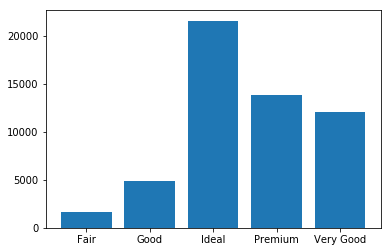

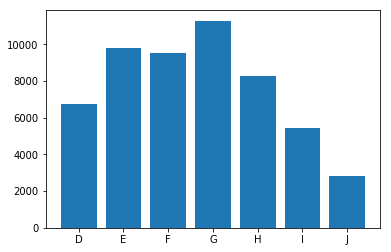

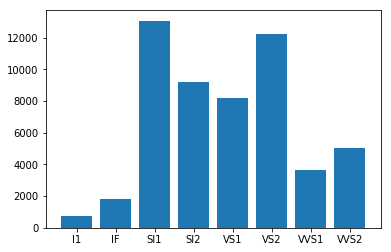

In [8]:
for label in feat_labels:
    unique, counts = np.unique(df[label].values, return_counts=True)
    ind = np.arange(len(unique))
    plt.bar(ind,counts)
    plt.xticks(ind, unique)
    plt.show()

The only significant attention must be given to low quantity of boft only fairly cut diamonds and to the dimmest of diamonds.

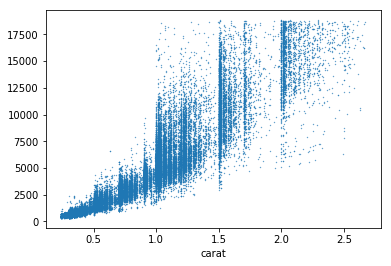

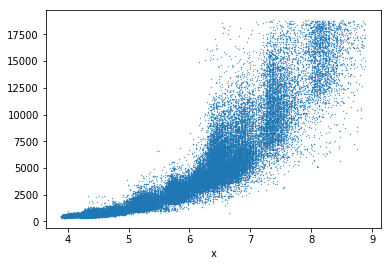

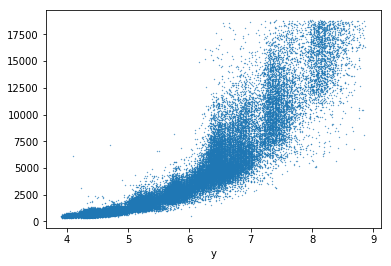

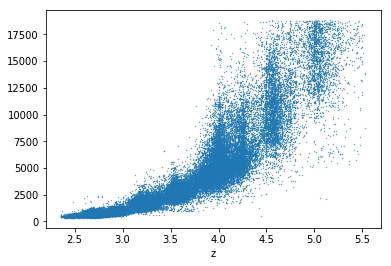

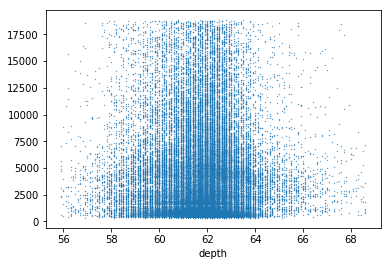

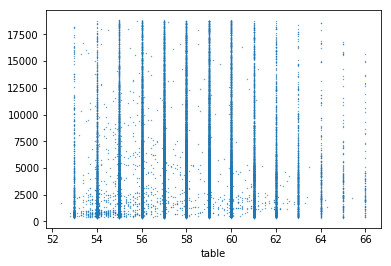

In [9]:
for label in num_labels:
    if label != 'price':
        data = df[label].values
        data, price = robust_pair(data, df['price'].values, 0.001)
        plt.scatter(data, price, s = 0.1)
        plt.xlabel(label)
        plt.show()

Carat, x, y and z variables seem to have positive dependency on the price. Because of the distribution of the data it is hard to see if there exists any trends in depth or table.

For curiosity let's also look at categorical variables.

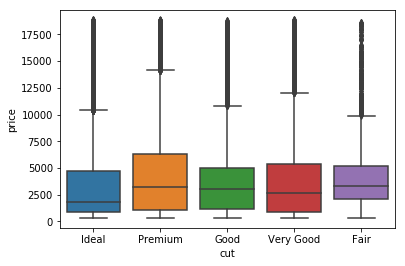

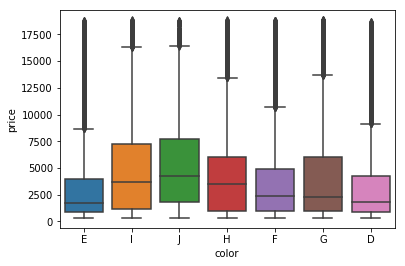

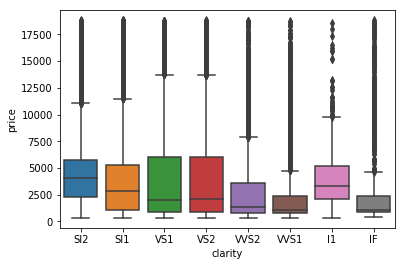

In [10]:
for label in feat_labels:
    sns.boxplot(x = label, y = 'price', data = df)
    plt.show()

Each categorial variable seems to have really long tails on high price size and they seem to have only a minor effect on the price.

# Variable selection

We are going to perform variable selection for predicting diamond pricing. Our hypothesis is that carat of the diamond has high effect on diamond pricing and the dimensional variables are completely redundant since the information about diamond size is included in carat. We will first examine dimensional variables of the diamond using linear model.

Let us first define linear model for predicting the price of diamonds.



$price_i = \boldsymbol{\beta}^T \boldsymbol{x}_i + \beta_0 $

Where $\hat\beta_1$ represents the coefficient vector for the model and $\beta_0$ represents the constant term.

Our model assumes that all the variables have linear dependence on the price and that they are linearly independent. This might not be the case and we will examine it's implications later. Also we assume that variance of all variables are same. To ensure this we are going to use standard scaler to standardize the features. This is done by taking the difference of datapoint and mean and dividing it by standard deviation [3].

$x_{standard} = (x - \bar{x})/\sigma$

## Backward selection

Lets fit the linear model to data and analyze the p-values of variables.

In [11]:
price = df['price'].values
labels = ['carat', 'depth', 'table', 'x', 'y', 'z']
num_data = df[labels].values

In [12]:
def calculate_p(x, y, y_hat, model_params):
    tmp = np.hstack((np.ones((x.shape[0],1)),x))
    MSE = sum((y - y_hat) ** 2) / (len(tmp) - len(tmp[0]))
    std = np.sqrt(MSE * (np.linalg.inv(np.dot(tmp.T,tmp)).diagonal()))
    ts = model_params / std
    p_vals = [2 * (1 - stats.t.cdf(np.abs(i),(len(tmp)-1))) for i in ts]
    return p_vals

In [13]:
# this is for testing purposes
def regress(lab, dp):
    lm = LinearRegression()
    data = df[lab].values
    x_train, x_test, y_train, y_test = train_test_split(data,price,test_size = dp, random_state = 123)
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_train)
    lm.fit(x_train, y_train)
    predict_data = lm.predict(x_train)
    p_vals = calculate_p(x_train, y_train, predict_data, np.append(lm.intercept_,lm.coef_))
    return p_vals

def print_table(p_vals, lab):
    table = [["","p-values"]]
    for i in range(len(lab)):
        table.append([lab[i], p_vals[i + 1]])
    display(HTML(tabulate.tabulate(table, tablefmt='html')))

def exe(lab, dp):
    print_table(regress(lab, dp),lab)

Lets start with normal backwards selection with small $\alpha = 0.01$

In [14]:
labels = ['carat', 'depth', 'table', 'x', 'y', 'z']
exe(labels, 0)

,p-values
carat,0.0
depth,0.0
table,0.0
x,0.0
y,0.009365715114277195
z,0.34743781807518137


In [15]:
labels = ['carat', 'depth', 'table', 'x', 'y']
exe(labels, 0)

,p-values
carat,0.0
depth,0.0
table,0.0
x,0.0
y,0.005935560796651362


Now all the values are above chosen alpha. This would be the chosen model. Because we wanted to find the best predictors for the price we will continue reducing variables. Because of 64 bit floats aren't accurate enought to capture such a small p-value we will take a persent sample from the dataset. This isn't reliable method for finding the best variables, but it should indicate what the result should be.

In [16]:
labels = ['carat', 'depth', 'table', 'x', 'y', 'z']
exe(labels, 0.99)

,p-values
carat,0.0
depth,0.7653822614808696
table,0.16344826728014095
x,0.30691362550418955
y,0.003511683284457945
z,0.33977354994206777


In [17]:
labels = ['carat', 'table', 'x', 'y', 'z']
exe(labels, 0.99)

,p-values
carat,0.0
table,0.15721281162513434
x,0.02444560600681811
y,0.0008274966059742539
z,0.002724469772699134


In [18]:
labels = ['carat', 'x', 'y', 'z']
exe(labels, 0.99)

,p-values
carat,0.0
x,0.011339935687471492
y,0.0006346885696557614
z,0.006050940095417623


In [19]:
labels = ['carat', 'y', 'z']
exe(labels, 0.99)

,p-values
carat,0.0
y,0.013859389635520358
z,0.0003566175906331015


In [20]:
labels = ['carat', 'z']
exe(labels, 0.99)

,p-values
carat,0.0
z,0.006678459503991485


In [21]:
labels = ['carat']
exe(labels, 0.99)

,p-values
carat,0.0


# LASSO

In LASSO we create a linear predictor. However to make it more robust we penalize the coefficients. Instead of just minimizing the redisidual we also try to minimize the coeffiecients. To achieve this we formulate a new cost function

$C = ||y - Xw||^2_2 + \alpha \cdot ||w||_1$

where $\alpha$ is the penalization coefficient

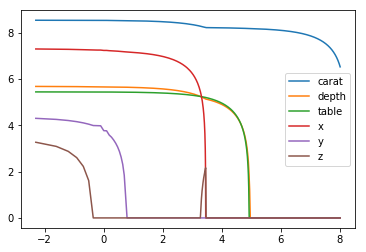

In [22]:
labels = ['carat','depth', 'table', 'x', 'y', 'z']
X = df[labels].values
y = df['price'].values
col = []
alpha = []
X = StandardScaler().fit_transform(X)
placeholder = 0.1
alphas = np.arange(0.1,3000,0.1)
model = Lasso(placeholder, warm_start = True)
for i in alphas:
    model.set_params(alpha = i)
    alpha.append(np.log(i))
    model.fit(X,y)
    col.append(np.log(np.abs(model.coef_) + 1))
plt.plot(alpha, col)
plt.legend(labels)
plt.show()

Unlike the p-values LASSO seems to value relevance of depth and table more. This might be due to table and depth being less linearly dependent, but with less covariance than x,y and z. This would also explain why those measurements are taken in the first place.

Let us find the best values of alpha using cross-validation.

In [35]:
X = df[labels].values #back to regular data to avoid data leakage
model = LassoCV(cv = 10, alphas = alphas, normalize = True).fit(X,y)
print(model.alpha_)
model = LassoCV(cv = 10, alphas = np.arange(0.001,0.01,0.001), normalize = True).fit(X,y)
print(model.alpha_)
model = LassoCV(cv = 10, alphas = np.arange(0.0001,0.001,0.0001), normalize = True).fit(X,y)
print(model.alpha_)
model = LassoCV(cv = 10, alphas = np.arange(0.000001,0.00001,0.000001), normalize = True).fit(X,y)
print(model.alpha_)
print("Carat coef = " + str(model.coef_[0]))

0.1
0.001
0.0001
1e-06
Carat coef = 10686.2888426


Although it seems that leaving x,y and z variables might be a good method for reducing explanatory variables it seems that they are useful at predicting the prices.

Lets analyze our assumptions of data being uncorrelated.

In [29]:
labels = ['carat', 'depth', 'table', 'x', 'y', 'z']
corr = df[labels].corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,carat,depth,table,x,y,z
carat,1,0.028,0.18,0.98,0.95,0.95
depth,0.028,1,-0.3,-0.025,-0.029,0.095
table,0.18,-0.3,1,0.2,0.18,0.15
x,0.98,-0.025,0.2,1,0.97,0.97
y,0.95,-0.029,0.18,0.97,1,0.95
z,0.95,0.095,0.15,0.97,0.95,1


It seems that x,y,z and carat of the diamond are highly correlated. How ever thats not a problem since LASSO is often robust at selecting the best variables then distiction between relevance of variables is noticible. Carat was found to be the most reliable predictor also by the backward selection so we can rely on our results.

# Conclusions

It seems that our hypothesis of carat being the most important dimensional predictor of the diamond pricing was correct. However it seems that prediction of other dimensions being redundant wasn't true. Lasso analysis showed that depth and table of the diamonds seem to be quite important. More importantly LASSO cross-validation showed that the best model is obtained without the penalization. This means that all variables should be important for predicting the price of the diamond.

Using statistical models we have compared dimensional properties of the diamond such as carat, length, width, depth, width of the diamond relative to widest point and the depth presentage of the diamond. We found that the all variables are valid predictors of the diamond price. It seems though that carat of the diamond is superior at predicting the value of diamond. Width relative to widest point and depth presentage were also found to be quite useful.

Analysis could be continued by trying non-linear models. Then the variable selection would have to be done by more effiecient methods such as Branch-and-Bound algorithms. We could also try to divide prices into bins and use gradient boosting algorithm for finding the relevance of different variables.

Also it would be interesting to know how important categorial variables such as cut, color, and clarity are for pricing of diamonds.

## References

[1] R-documentation, diamond prices, https://vincentarelbundock.github.io/Rdatasets/doc/ggplot2/diamonds.html

[2] Sklearn-documentation, LASSO, https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_lars.html

[3] Sklearn-documentation , StandardScaler, https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html